In [8]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

import pandas as pd
from pyhandy import get_data_summary
import unicodedata

weather_df = pd.read_feather("../01-data/processed/weather_data.feather")
weather_df["time"] = weather_df.time.dt.tz_localize("UTC")

aq_df = (
    pd.read_feather('../01-data/interim/aq_ayto_madrid-sin-imputar.feather')
     .set_index(['fecha','estacion','variable'])['value']
     .unstack()
     .sort_values('fecha')
     .reset_index()
     .rename_axis(columns=[''])
     .rename(columns={'fecha':'time'})
)
aq_df["time"] = aq_df.time\
                    .dt.tz_localize("Europe/Madrid",ambiguous="NaT",nonexistent="shift_forward")\
                        .dt.tz_convert("UTC")
aq_df = aq_df.dropna(subset=["time"])
aq_df = aq_df[aq_df.time.isin(weather_df.time)].reset_index()
aq_df.to_feather("../01-data/processed/air_quality_data.feather")
weather_df = weather_df[weather_df.time.isin(aq_df.time)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
aq_air_dfs = {}
aq_station_datasets_names = {}
for estacion in aq_df.estacion.unique():
    aq_estacion_df = aq_df[aq_df.estacion==estacion].dropna(how="all",axis=1)\
        .drop(columns=["estacion"]).set_index("time")\
            .interpolate(limit=6)
    aq_estacion_df.columns = aq_estacion_df.columns.str.replace("µ","u")
    weather_estacion_df = weather_df.set_index("time")
    weather_estacion_df = weather_estacion_df.loc[weather_estacion_df.index.intersection(aq_estacion_df.index)]
    aq_estacion_df = aq_estacion_df.loc[weather_estacion_df.index]
    weather_estacion_df = weather_estacion_df.loc[aq_estacion_df.index]
    # Create the dataset of integrated weather/air-quality data for the given station
    estacion_df = pd.concat([aq_estacion_df,weather_estacion_df],axis=1).rename_axis("time").reset_index().dropna()
    # Save as csv file
    dataset_name = estacion.lower().replace(" ","_").replace(".","").replace("/","_")
    dataset_name = "aq_weather_"+unicodedata.normalize('NFKD', dataset_name).encode('ASCII', 'ignore').decode("ASCII")
    estacion_df.to_csv(f"../01-data/processed/aq_weather_by_station/{dataset_name}.csv",index=False)
    aq_air_dfs[estacion] = estacion_df
    aq_station_datasets_names[estacion] = dataset_name

In [14]:
import json
json.dump(
    aq_station_datasets_names,
    open("../references/air_quality_data/aq_station_datasets_names.json","w")
)
# Air Quality Datasets
list(aq_station_datasets_names.values())

['aq_weather_plaza_eliptica',
 'aq_weather_vallecas',
 'aq_weather_urb_embajada_(barajas)',
 'aq_weather_tres_olivos',
 'aq_weather_sanchinarro',
 'aq_weather_retiro',
 'aq_weather_po_castellana',
 'aq_weather_pza_del_carmen',
 'aq_weather_pza_de_espana',
 'aq_weather_pza_castilla',
 'aq_weather_parque_juan_carlos_i',
 'aq_weather_villaverde_alto',
 'aq_weather_moratalaz',
 'aq_weather_arturo_soria',
 'aq_weather_av_ramon_y_cajal',
 'aq_weather_barajas',
 'aq_weather_barrio_del_pilar',
 'aq_weather_c__farolillo',
 'aq_weather_mendez_alvaro',
 'aq_weather_cuatro_caminos',
 'aq_weather_el_pardo',
 'aq_weather_ensanche_vallecas',
 'aq_weather_escuelas_aguirre',
 'aq_weather_casa_de_campo']

<AxesSubplot:xlabel='time', ylabel='no2_ug_m3'>

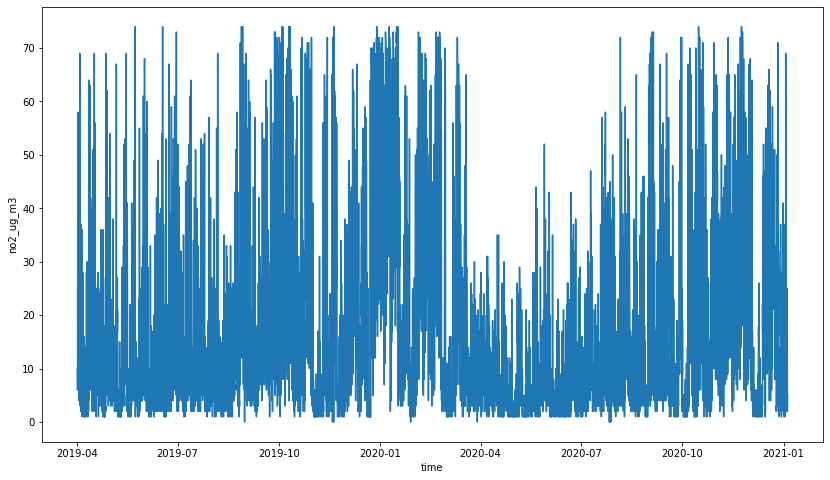

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

start,end = "2019-04-01","2022-01-01"
plt.figure(figsize=(14,8))
sns.lineplot(data=estacion_df[estacion_df.time.between(start,end)],x="time",y="no2_ug_m3")